#EmoBerta using Custom Loss Function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.26      0.38        23
           1       0.54      0.87      0.67        23

    accuracy                           0.57        46
   macro avg       0.60      0.57      0.52        46
weighted avg       0.60      0.57      0.52        46


Confusion Matrix:
[[ 6 17]
 [ 3 20]]


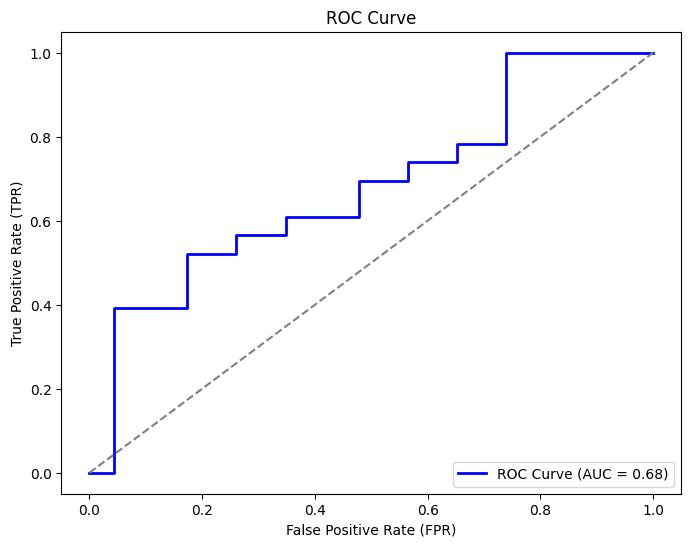

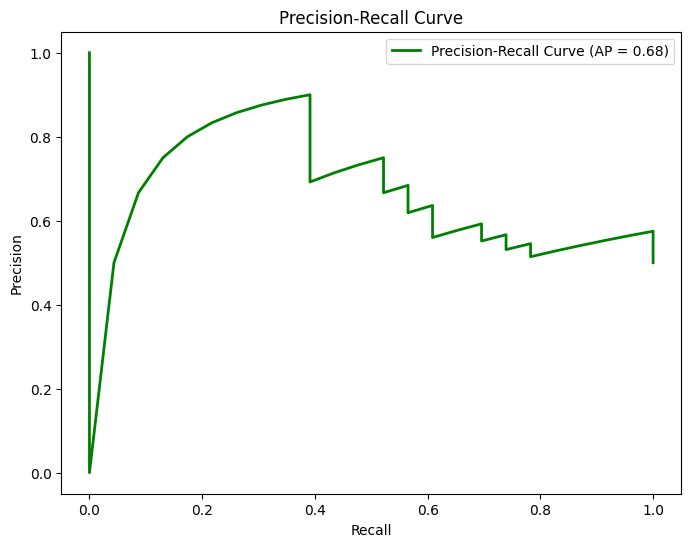

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)  # Ensure labels are of type Long
        }

# Prepare dataset
texts = df_balanced['cleaned_text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


# Calculate class weights
class_weights = torch.tensor([len(y_train) / (2 * np.bincount(y_train)[0]),
                              len(y_train) / (2 * np.bincount(y_train)[1])], dtype=torch.float32)  # Ensure class weights are Float
class_weights = class_weights.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function with class weights
loss_fn = CrossEntropyLoss(weight=class_weights)

# Modify training loop to use custom loss function
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')  # Do NOT convert to Float

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Use custom loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Adjust decision threshold to prioritize recall for maladaptive entries
y_pred = (np.array(y_pred_proba) > 0.3).astype(int)  # Lower threshold to increase recall

# Re-evaluate model with adjusted threshold
print("\nAdjusted Classification Report:")
print(classification_report(y_true, y_pred))

# Adjusted Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nAdjusted Confusion Matrix:")
print(cm)


Adjusted Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63        23
           1       0.65      0.87      0.74        23

    accuracy                           0.70        46
   macro avg       0.72      0.70      0.69        46
weighted avg       0.72      0.70      0.69        46


Adjusted Confusion Matrix:
[[12 11]
 [ 3 20]]


#EmoBerta using Focal Loss Function

Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62        23
           1       0.62      0.65      0.64        23

    accuracy                           0.63        46
   macro avg       0.63      0.63      0.63        46
weighted avg       0.63      0.63      0.63        46


Confusion Matrix:
[[14  9]
 [ 8 15]]


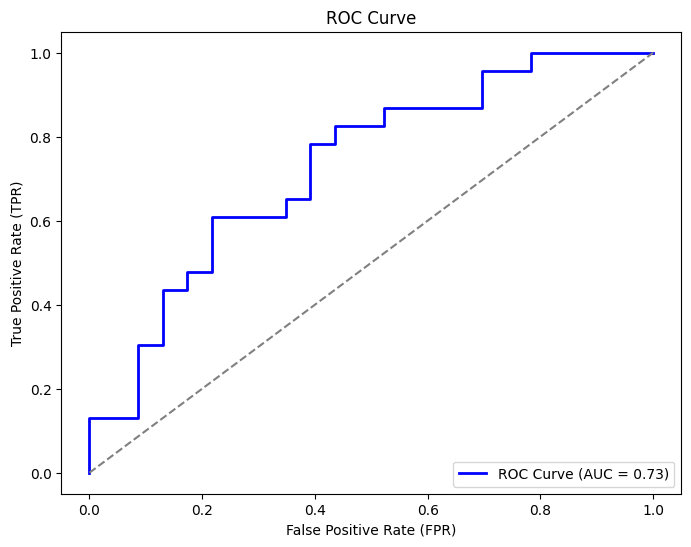

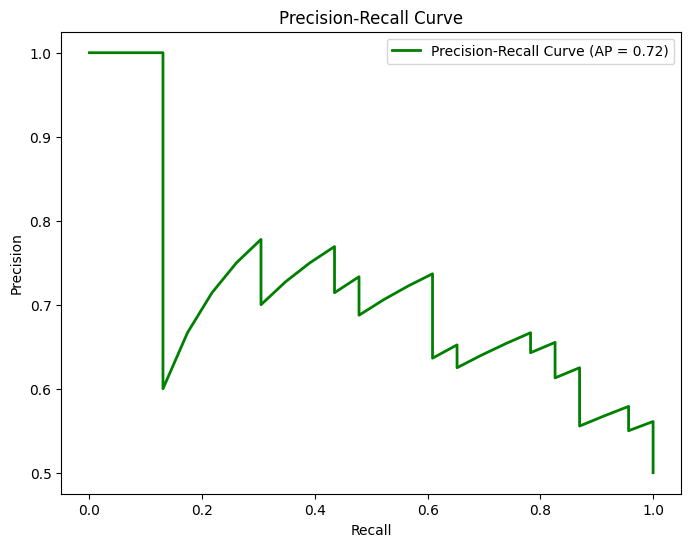

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torch.nn import functional as F


# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)  # Ensure labels are of type Long
        }

# Prepare dataset
texts = df_balanced['cleaned_text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


# Define Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Initialize focal loss
focal_loss_fn = FocalLoss(alpha=1, gamma=2)

# Training loop
model.train()
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = focal_loss_fn(logits, labels)  # Use focal loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()